In [2]:
import pandas as pd
import numpy as np
import scipy
import matplotlib.pyplot as plt
from tqdm import tqdm
from codebase.sparse_regression import *
from codebase.utils import *
import ipywidgets as widgets
from IPython.display import HTML, Markdown, display
from statsmodels.tsa.arima_model import ARIMA
import seaborn as sns
from sklearn.metrics import r2_score, mean_squared_error

%load_ext autoreload

In [3]:
class Model:
    
    def __init__(self, data, params):
        self.data = data
        self.params = params
    
    def fit(self, data):
        raise NotImplementedError()
    
    def predict(self, x):
        raise NotImplementedError()

               
class SysId(Model):
    
    def fit(self, verbose=0):
        targets, X = make_targets(self.data.reshape(-1, 1), derivative=False)
        augmented, _ = make_polynomials(X, max_degree=self.params['max_degree'])
        self.weights, _ = sparse_regression(augmented, targets, cutoff=self.params['cutoff'])
        if verbose == 1:
            return show_weights(self.weights, derivative=False)
        if verbose == 2:
            string = '$$x_{t+1} = ' + str(self.weights[0, 0].numpy()) 
            string += ' + ' + str(self.weights[1, 0].numpy()) + ' \\times x_t'
            for i, w in enumerate(self.weights[2:]):
                string += ' + ' + str(w[0].numpy()) + ' \\times x_t^' + str(i+2)
            string += '$$'
            return display(Markdown(string))
    
    def predict(self, x):
        augmentation, _ = make_polynomials(x, max_degree=self.params['max_degree'])
        return (augmentation.reshape(1, -1) @ self.weights).numpy()
    
    def trajectory(self, initial_condition, length):
        trajectory = [np.array(initial_condition)]
        for k in range(length):
            trajectory.append(self.predict(trajectory[k]))
        return np.array(trajectory)
    
    def extrapolate(self, n=14, lookback=1):
        last_state = self.data[-lookback]
        trajectory = np.clip(self.trajectory([last_state], n), a_max=last_state*3, a_min=0)
        trajectory[(trajectory == last_state*3) | (trajectory == 0)] = np.nan
        return np.concatenate((np.full((len(self.data[:-lookback]), 1), np.nan), trajectory))

class NN(Model):
    
    def fit(self, verbose=0):
        self.model = tf.keras.models.Sequential([
            tf.keras.layers.Dense(20, 'relu'),
            tf.keras.layers.Dense(50, 'relu'),
            tf.keras.layers.Dense(50, 'relu'),
            tf.keras.layers.Dense(50, 'relu'),
            tf.keras.layers.Dense(50, 'relu'),
            tf.keras.layers.Dense(50, 'relu'),
            tf.keras.layers.Dense(20, 'relu'),
            tf.keras.layers.Dense(1),
        ])
        self.model.compile('adam', 'MSE')
        targets, X = make_targets(self.data.reshape(-1, 1), derivative=False)
        self.model.fit(X, targets, epochs=100, batch_size=16, verbose=0)
    
    def predict(self, x):
        return self.model.predict(x)
    
    def trajectory(self, initial_condition, length):
        trajectory = [np.array(initial_condition)]
        for k in range(length):
            trajectory.append(self.predict(trajectory[k].reshape(-1, 1))[0])
        return np.array(trajectory)
    
    def extrapolate(self, n=14, lookback=1):
        last_state = self.data[-lookback]
        trajectory = np.clip(self.trajectory([last_state], n), a_max=last_state*3, a_min=0)
        trajectory[(trajectory == last_state*3) | (trajectory == 0)] = np.nan
        return np.concatenate((np.full((len(self.data[:-lookback]), 1), np.nan), trajectory))


        
        

In [5]:
%autoreload

dataset = CountryDataset()

In [4]:
countries = dataset.all_hopkins_countries()
max_degrees = [2, 3, 4, 5, 6, 7]

In [5]:

def forecast(country, max_degree):
    forecast = 14
    
    country_data = dataset.cumulative(country, rescaling=10000)
    sysid = SysId(country_data[:-forecast], {'max_degree': max_degree, 'cutoff': 1e-20})
    sysid.fit(verbose=2)

    plt.figure(dpi=100)
    f, (ax1, ax2) = plt.subplots(1, 2, dpi=100, figsize=(12, 3))

    ax1.plot(country_data, 'k.', label='real values')
    ax1.plot(sysid.extrapolate(forecast*2), label='forecast')
    ax1.set_title(country)
    ax1.set_ylabel('cases/1000')
    ax1.set_xlabel('time')
    ax1.legend()
    
    t = range(len(country_data) - 2*forecast, len(country_data))
    ax2.plot(t, country_data[-forecast*2:], 'k.', label='real values')
    ax2.plot(t, sysid.extrapolate(forecast)[-forecast*2:], label='forecast')
    ax2.set_title('Zoomed on prediction')
    ax2.set_ylabel('cases/1000')
    ax2.set_xlabel('time')
    plt.show()
    
widgets.interact(forecast, country=countries, max_degree=max_degrees);

interactive(children=(Dropdown(description='country', options=('Afghanistan', 'Albania', 'Algeria', 'Andorra',…

interactive(children=(Dropdown(description='country', options=('Afghanistan', 'Albania', 'Andorra', 'Angola', …

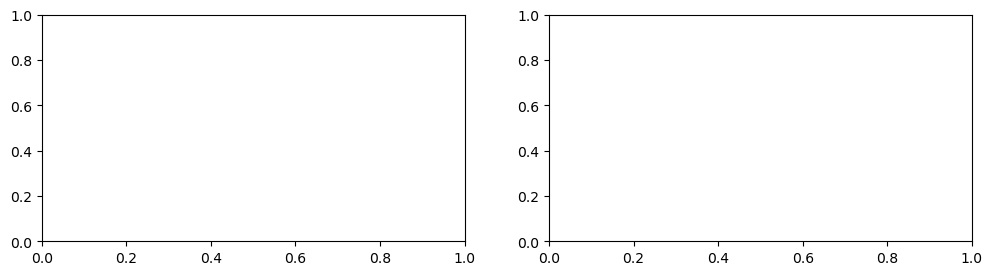

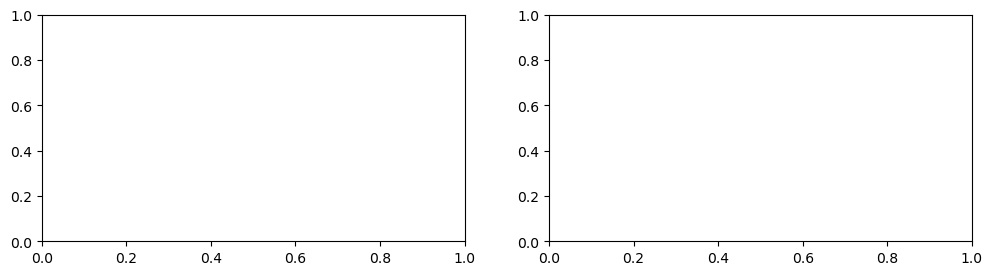

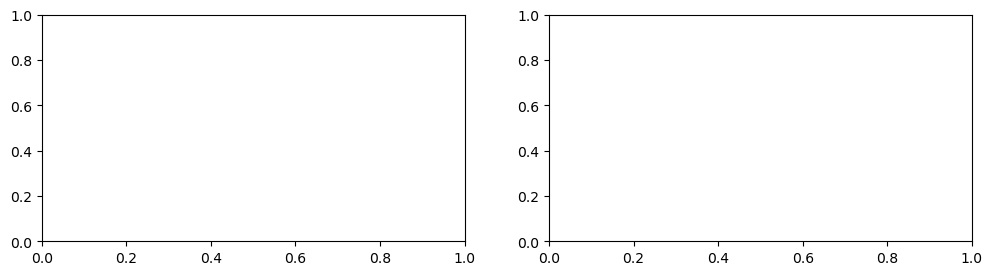

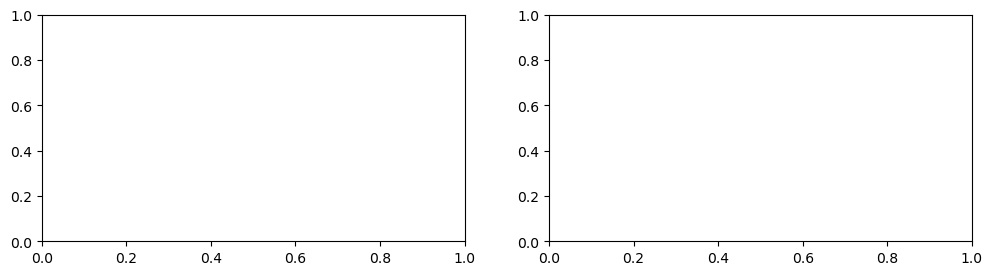

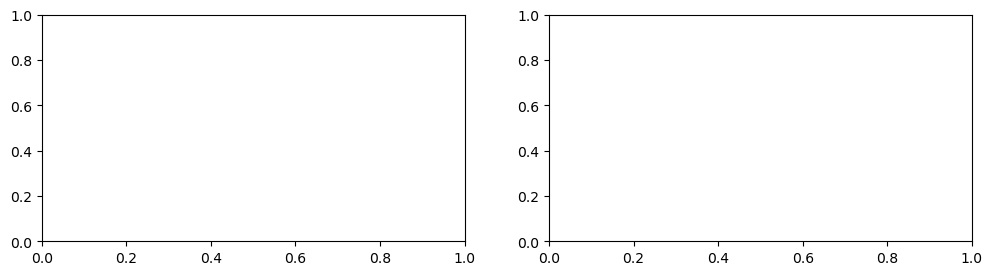

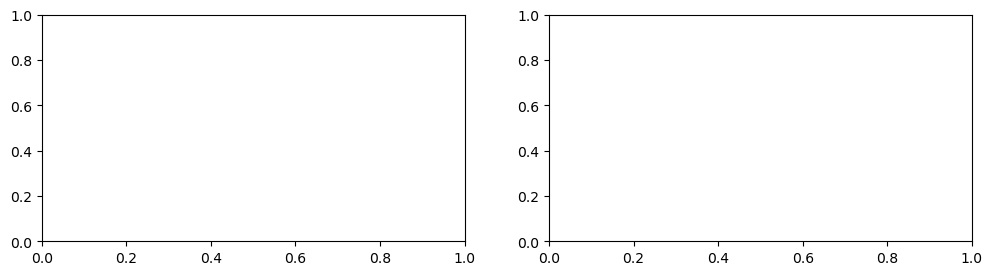

In [14]:
lookback = 0.5
countries = dataset.all_hopkins_countries()

def forecast(country):
    forecast = 14
    degrees = [2, 3, 4, 5, 6, 7]
    
    country_data = dataset.cumulative(country, rescaling=10000)
    f, (ax1, ax2) = plt.subplots(1, 2, dpi=100, figsize=(12, 3))
    t = range(len(country_data) - int(forecast*(lookback + 1)), len(country_data))
    
    a = ARIMA(country_data[:-forecast], (1, 1, 3))
    a = a.fit()
    
    prediction = a.predict(start=len(country_data[:-forecast]), end=len(country_data) + forecast)
    prediction = np.concatenate([np.full_like(country_data[:-forecast], np.nan), np.cumsum(prediction) + country_data[-forecast-2]])
    ax1.plot(country_data, 'k.', label='real values')
    ax2.plot(t, country_data[-int(forecast*(lookback + 1)):], 'k.', label='real values')
    for degree in degrees:
        sysid = SysId(country_data[:-forecast], {'max_degree': degree, 'cutoff': 1e-20})
        sysid.fit()

        ax1.plot(sysid.extrapolate(forecast*2), label=f'max degree: {degree}')
        ax2.plot(t, sysid.extrapolate(forecast)[-int(forecast*(lookback + 1)):])
        


    
    ax1.plot(prediction, '--', label='ARIMA forecast')
    ax1.set_title(country)
    ax1.set_ylabel('x 1e5 cases')
    ax1.set_xlabel('time')
    ax1.legend()
    
    

    ax2.plot(t, prediction[-int(forecast*(2 + lookback)):-int(forecast)], '--', label='ARIMA forecst')
    ax2.set_title('Zoomed on prediction')
    ax2.set_ylabel('x 1e5 cases')
    ax2.set_xlabel('time')
    plt.show()
    return HTML('''<script>
$( document ).ready($('div.output_stderr').hide());
</script>''')
    

    
widgets.interact(forecast, country=results['countries'], max_degree=max_degrees);


In [13]:
forecast = 14
degrees = [2, 3, 4, 5, 6, 7]

def mean_squared_error(a, b):
    return ((a - b)**2).mean()

results = {'one_week': {
                # 'r2': [],
                'mse': []
            },
           'two_weeks': {
               # 'r2': [],
               'mse': []
           },
          'countries': []}

for country in dataset.all_hopkins_countries():
    one_week = []
    two_weeks = []
    
    country_data = dataset.cumulative(country, rescaling=-1)
    train_data = country_data[:-forecast]
    try:
        a = ARIMA(train_data, (1, 1, 4))
        a = a.fit()

        prediction = np.cumsum(a.predict(start=len(train_data), end=len(country_data)-1))+ train_data[-2]
        # plt.plot(np.concatenate((train_data, prediction)))
        # plt.show()
        one_week.append(mean_squared_error(prediction[:-forecast//2], country_data[-forecast:-forecast//2]))
        two_weeks.append(mean_squared_error(prediction, country_data[-forecast:]))
        
#         nn = NN(train_data, {})
#         nn.fit()
        
#         prediction = nn.extrapolate(forecast*2)
#         one_week.append(mean_squared_error(prediction[-forecast:-forecast//2], country_data[-forecast:-forecast//2]))
#         two_weeks.append(mean_squared_error(prediction[-forecast:], country_data[-forecast:]))
        for degree in degrees:
            sysid = SysId(train_data, {'max_degree': degree, 'cutoff': 1e-20})
            sysid.fit()
            trajectory = sysid.extrapolate(forecast*2)
            one_week.append(mean_squared_error(trajectory[-forecast:-forecast//2], country_data[-forecast:-forecast//2]))
            two_weeks.append(mean_squared_error(trajectory[-forecast:], country_data[-forecast:]))
        results['one_week']['mse'].append(one_week)
        results['two_weeks']['mse'].append(two_weeks)
        results['countries'].append(country)
    
    # except NotImplementedError:
    #     pass
            
    except ValueError:
        print(f"Couldn't do {country}")
        
    except np.linalg.LinAlgError:
        print(f"Couldn't do {country}")


c:\program files\python38\lib\site-packages\statsmodels\tsa\kalmanf\kalmanfilter.py:218: RuntimeWarning: divide by zero encountered in true_divide
  loglike, sigma2 = kalman_loglike.kalman_loglike_double(
c:\program files\python38\lib\site-packages\statsmodels\tsa\tsatools.py:689: RuntimeWarning: overflow encountered in exp
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
c:\program files\python38\lib\site-packages\statsmodels\tsa\tsatools.py:689: RuntimeWarning: invalid value encountered in true_divide
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
c:\program files\python38\lib\site-packages\statsmodels\tsa\tsatools.py:690: RuntimeWarning: overflow encountered in exp
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
c:\program files\python38\lib\site-packages\statsmodels\tsa\tsatools.py:690: RuntimeWarning: invalid value encountered in true_divide
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
C:\Users\kipr\AppData\Roaming\Python\Python38

Couldn't do Algeria
Couldn't do Armenia
Couldn't do Austria
Couldn't do Bahamas
Couldn't do Bahrain
Couldn't do Bangladesh
Couldn't do Belarus
Couldn't do Belgium


c:\program files\python38\lib\site-packages\statsmodels\base\model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warn('Inverting hessian failed, no bse or cov_params '


Couldn't do Bolivia
Couldn't do Brazil
Couldn't do Brunei
Couldn't do Bulgaria
Couldn't do Canada
Couldn't do Chile
Couldn't do China
Couldn't do Colombia


c:\program files\python38\lib\site-packages\statsmodels\tsa\tsatools.py:716: RuntimeWarning: divide by zero encountered in true_divide
  invmacoefs = -np.log((1-macoefs)/(1+macoefs))


Couldn't do Congo (Kinshasa)
Couldn't do Cote d'Ivoire
Couldn't do Cyprus
Couldn't do Czechia
Couldn't do Dominican Republic
Couldn't do Ecuador
Couldn't do Egypt
Couldn't do El Salvador
Couldn't do Estonia
Couldn't do Ethiopia
Couldn't do Finland


c:\program files\python38\lib\site-packages\statsmodels\base\model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warn('Inverting hessian failed, no bse or cov_params '
c:\program files\python38\lib\site-packages\statsmodels\base\model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warn('Inverting hessian failed, no bse or cov_params '


Couldn't do Greece


c:\program files\python38\lib\site-packages\statsmodels\base\model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warn('Inverting hessian failed, no bse or cov_params '
c:\program files\python38\lib\site-packages\statsmodels\base\model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warn('Inverting hessian failed, no bse or cov_params '
c:\program files\python38\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
c:\program files\python38\lib\site-packages\statsmodels\base\model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warn('Inverting hessian failed, no bse or cov_params '


Couldn't do Honduras
Couldn't do Hungary
Couldn't do India
Couldn't do Indonesia
Couldn't do Kuwait
Couldn't do Lithuania
Couldn't do Madagascar
Couldn't do Mexico
Couldn't do Mongolia
Couldn't do Morocco
Couldn't do Nigeria
Couldn't do North Macedonia
Couldn't do Norway


c:\program files\python38\lib\site-packages\statsmodels\tsa\tsatools.py:716: RuntimeWarning: invalid value encountered in log
  invmacoefs = -np.log((1-macoefs)/(1+macoefs))


Couldn't do Oman
Couldn't do Pakistan
Couldn't do Peru
Couldn't do Poland
Couldn't do Portugal
Couldn't do Qatar
Couldn't do Russia


c:\program files\python38\lib\site-packages\statsmodels\base\model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warn('Inverting hessian failed, no bse or cov_params '
c:\program files\python38\lib\site-packages\statsmodels\base\model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warn('Inverting hessian failed, no bse or cov_params '


Couldn't do Saudi Arabia
Couldn't do Slovakia
Couldn't do Slovenia


c:\program files\python38\lib\site-packages\statsmodels\base\model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warn('Inverting hessian failed, no bse or cov_params '


Couldn't do South Africa
Couldn't do Sudan
Couldn't do Tanzania
Couldn't do Togo
Couldn't do Ukraine
Couldn't do United Arab Emirates


c:\program files\python38\lib\site-packages\statsmodels\base\model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warn('Inverting hessian failed, no bse or cov_params '


Couldn't do Uruguay
Couldn't do Uzbekistan
Couldn't do Mozambique
Couldn't do Timor-Leste
Couldn't do Libya


c:\program files\python38\lib\site-packages\statsmodels\base\model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warn('Inverting hessian failed, no bse or cov_params '


Couldn't do Mali


c:\program files\python38\lib\site-packages\statsmodels\base\model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warn('Inverting hessian failed, no bse or cov_params '


Couldn't do Malawi


c:\program files\python38\lib\site-packages\statsmodels\base\model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warn('Inverting hessian failed, no bse or cov_params '


Couldn't do Yemen
Couldn't do Comoros
Couldn't do Tajikistan
Couldn't do Lesotho


c:\program files\python38\lib\site-packages\statsmodels\regression\linear_model.py:889: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
c:\program files\python38\lib\site-packages\statsmodels\tsa\ar_model.py:1699: RuntimeWarning: divide by zero encountered in log
  return np.log(self.sigma2) + 2 * (1 + self.df_model) / self.nobs
c:\program files\python38\lib\site-packages\statsmodels\tsa\ar_model.py:1741: RuntimeWarning: divide by zero encountered in log
  return np.log(self.sigma2) + (1 + self.df_model) * np.log(nobs) / nobs
c:\program files\python38\lib\site-packages\statsmodels\tsa\ar_model.py:1713: RuntimeWarning: divide by zero encountered in log
  log_sigma2 = np.log(self.sigma2)
c:\program files\python38\lib\site-packages\statsmodels\tsa\arima_model.py:849: RuntimeWarning: divide by zero encountered in log
  llf = -nobs / 2. * (log(2 * pi) + log(sigma2)) - ssr / (2 * sigma2)
c:\program files\python38\lib\site-pa

In [ ]:
mses = 

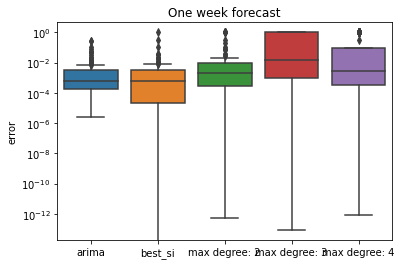

In [26]:
one_week_df = pd.DataFrame(results['one_week']['mse'], columns=['arima', 'max degree: 2', 'max degree: 3', 'max degree: 4', 'max degree: 5', 'max degree: 6', 'max degree: 7'])
one_week_df = one_week_df.fillna(1)

one_week_df['best_si'] = one_week_df[['max degree: 2', 'max degree: 3', 'max degree: 4', 'max degree: 5', 'max degree: 6', 'max degree: 7']].min(axis=1)

ax = sns.boxplot(data=one_week_df[['arima', 'best_si', 'max degree: 2', 'max degree: 3', 'max degree: 4']])
ax.set_yscale('log')
ax.set_ylabel('error')
ax.set_title('One week forecast')
plt.show()

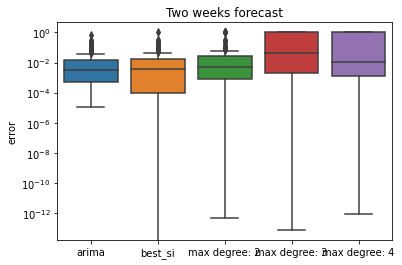

In [27]:
two_weeks_df = pd.DataFrame(results['two_weeks']['mse'], columns=['arima', 'max degree: 2', 'max degree: 3', 'max degree: 4', 'max degree: 5', 'max degree: 6', 'max degree: 7'])
two_weeks_df = two_weeks_df.fillna(1)
two_weeks_df['country'] = results['countries']

two_weeks_df['best_si'] = two_weeks_df[['max degree: 2', 'max degree: 3', 'max degree: 4', 'max degree: 5', 'max degree: 6', 'max degree: 7']].min(axis=1)

ax = sns.boxplot(data=two_weeks_df[['arima', 'best_si', 'max degree: 2', 'max degree: 3', 'max degree: 4']])
ax.set_yscale('log')
ax.set_ylabel('error')
ax.set_title('Two weeks forecast')
plt.show()

In [24]:
two_weeks_df[['arima', 'best_si']].describe()

,arima,best_si
count,117.000000,117.000000
mean,0.029784,0.033694
std,0.082067,0.105473
min,0.000012,0.000000
25%,0.000496,0.000090
50%,0.003003,0.003581
75%,0.014711,0.017801
max,0.686994,1.000000


In [ ]:
0.024458/0.036378

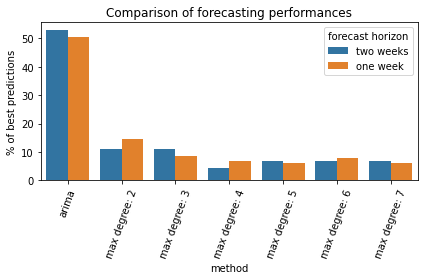

In [30]:
two = two_weeks_df[['arima', 'max degree: 2', 'max degree: 3', 'max degree: 4', 'max degree: 5', 'max degree: 6', 'max degree: 7']].idxmin(axis=1).value_counts().to_frame().reset_index()
two.columns = ['method', 'nb_best']
two['forecast horizon'] = 'two weeks'
two['% of best predictions'] = 100*two['nb_best']/two['nb_best'].sum()

one = one_week_df[['arima', 'max degree: 2', 'max degree: 3', 'max degree: 4', 'max degree: 5', 'max degree: 6', 'max degree: 7']].idxmin(axis=1).value_counts().to_frame().reset_index()
one.columns = ['method', 'nb_best']
one['forecast horizon'] = 'one week'
one['% of best predictions'] = 100*one['nb_best']/one['nb_best'].sum()


all_weeks = two.append(one)


plt.xticks(rotation=70)

ax = sns.barplot(x="method", y="% of best predictions", hue="forecast horizon", data=all_weeks,
                 order=['arima', 'max degree: 2', 'max degree: 3', 'max degree: 4', 'max degree: 5', 'max degree: 6', 'max degree: 7'])


# plt.margins(0.2)
plt.subplots_adjust(bottom=0.15)
plt.title('Comparison of forecasting performances')
plt.tight_layout()
plt.savefig('forecasting.png', dpi=200)
plt.show()

In [ ]:
ax = one_week_df[['arima', 'best_si']].idxmin(axis=1).value_counts().plot(kind='bar')
ax.set_title('One week forecast')
ax.set_ylabel('nb of best forecasts')
plt.show()

In [ ]:
for i in np.where(np.argmin(one_week_df[['arima', '2', '3', '4', '5', '6', '7']].values, axis=1) == 0)[0]:
    print(results['countries'][i])

In [ ]:
for i in np.where(np.argmin(two_weeks_df[['arima', '2', '3', '4', '5', '6', '7']].values, axis=1) == 0)[0]:
    print(results['countries'][i])

In [ ]:
np.argmin(one_week_df[['arima', '2', '3', '4', '5', '6', '7']].values, axis=1)

In [ ]:
np.argmin(two_weeks_df[['arima', '2', '3', '4', '5', '6', '7']].values, axis=1)


In [ ]:
np.array(results['one_week']['mse'])

## Single figure clean plot

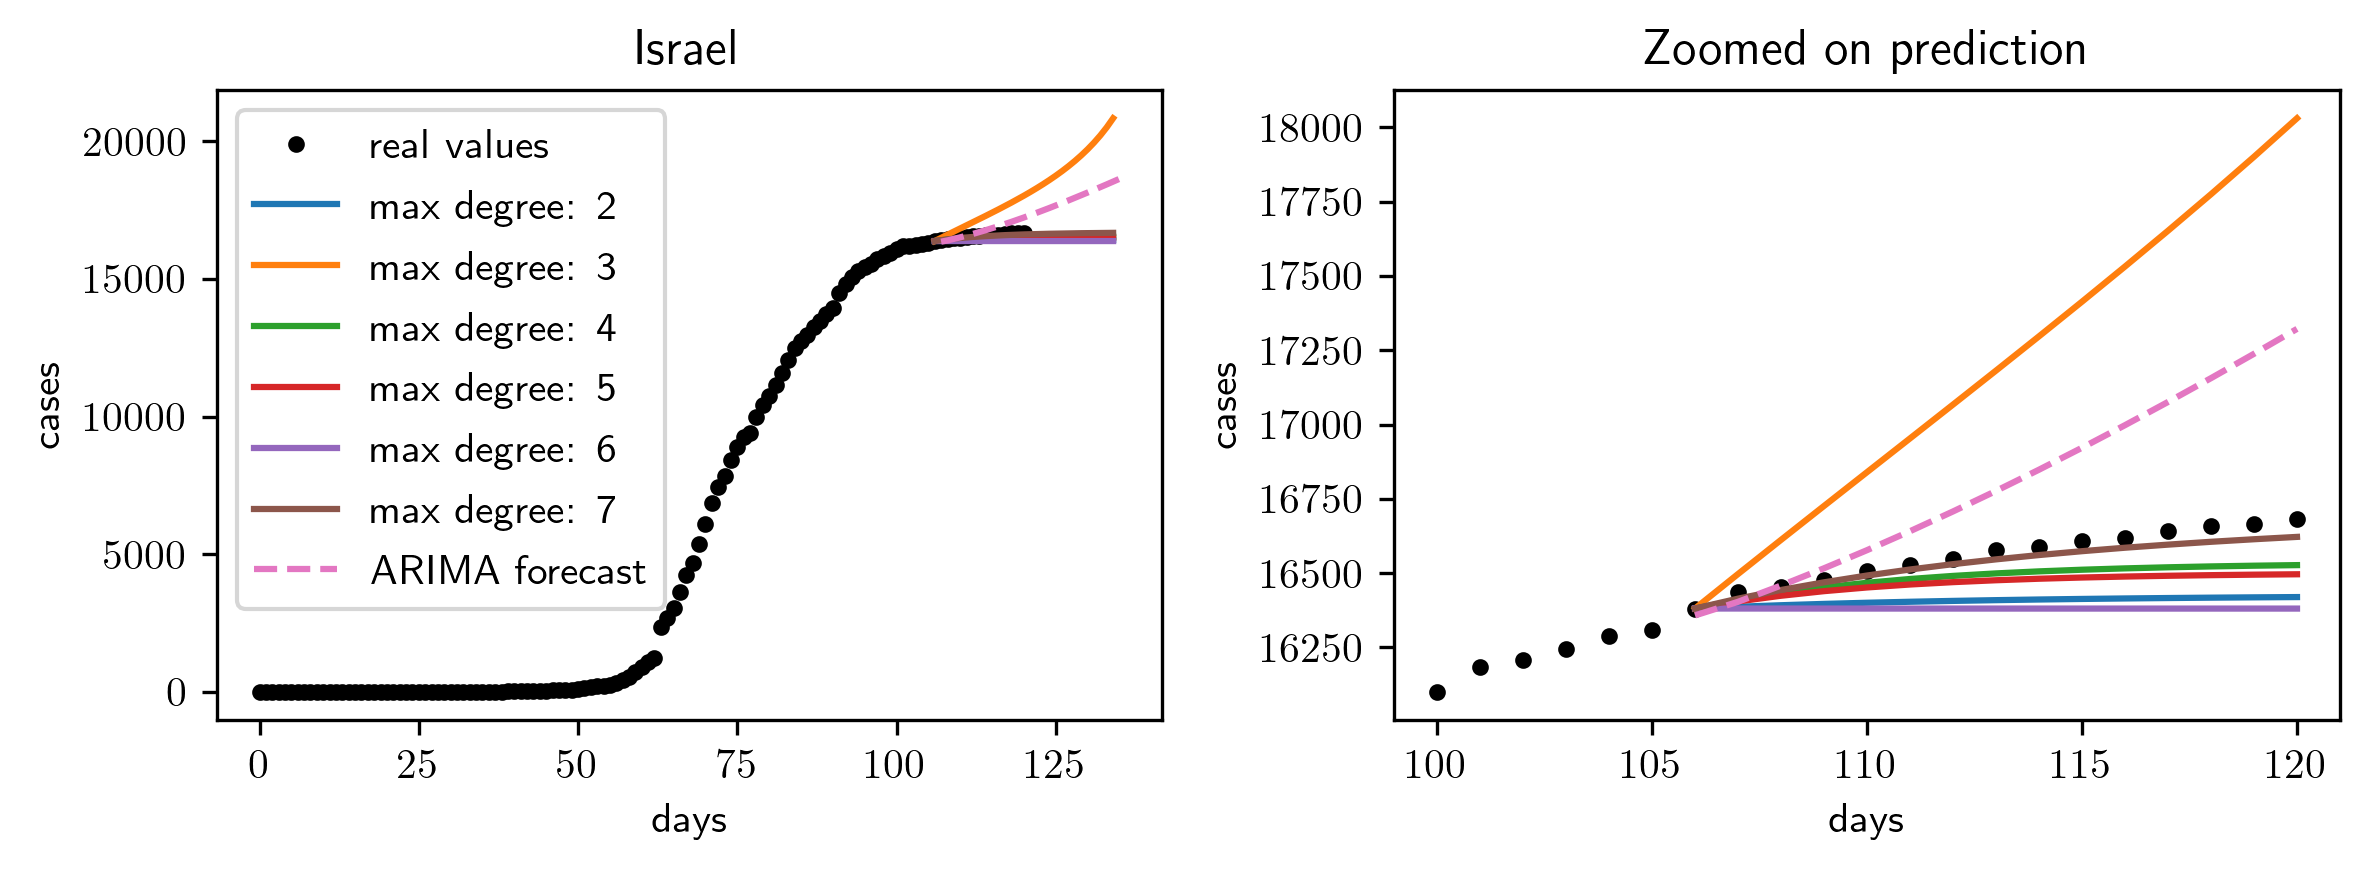

In [17]:
lookback = 0.5
country = "Israel"
forecast = 14
degrees = [2, 3, 4, 5, 6, 7]
import matplotlib
from matplotlib.ticker import MaxNLocator
matplotlib.rcParams['text.usetex'] = True

country_data = dataset.cumulative(country, rescaling=10000)
f, (ax1, ax2) = plt.subplots(1, 2, dpi=300, figsize=(8, 3))
t = range(len(country_data) - int(forecast*(lookback + 1)), len(country_data))

a = ARIMA(country_data[:-forecast], (1, 1, 3))
a = a.fit()

prediction = a.predict(start=len(country_data[:-forecast]), end=len(country_data) + forecast)
prediction = np.concatenate([np.full_like(country_data[:-forecast], np.nan), np.cumsum(prediction) + country_data[-forecast-2]])
ax1.plot(country_data*10000, 'k.', label='real values')
ax2.plot(t, country_data[-int(forecast*(lookback + 1)):]*10000, 'k.', label='real values')
for degree in degrees:
    sysid = SysId(country_data[:-forecast], {'max_degree': degree, 'cutoff': 1e-20})
    sysid.fit()

    ax1.plot(sysid.extrapolate(forecast*2)*10000, label=f'max degree: {degree}')
    ax2.plot(t, sysid.extrapolate(forecast)[-int(forecast*(lookback + 1)):]*10000)




ax1.plot(prediction*10000, '--', label='ARIMA forecast')
ax1.set_title(country)
ax1.set_ylabel('cases')
ax1.set_xlabel('days')
ax1.legend()



ax2.plot(t, prediction[-int(forecast*(2 + lookback)):-int(forecast)]*10000, '--', label='ARIMA forecst')
ax2.set_title('Zoomed on prediction')
ax2.set_ylabel('cases')
ax2.yaxis.set_major_locator(MaxNLocator(integer=True))
ax2.set_xlabel('days')
plt.tight_layout()
plt.savefig(f'{country}_forecast.png', dpi=300)
plt.show()
matplotlib.rcParams['text.usetex'] = False

$$x_{t+1} = 0.0045230514 + 1.2387929 \times x_t + -0.03079382 \times x_t^2 + 0.0013536195 \times x_t^3 + -2.0732323e-05 \times x_t^4$$

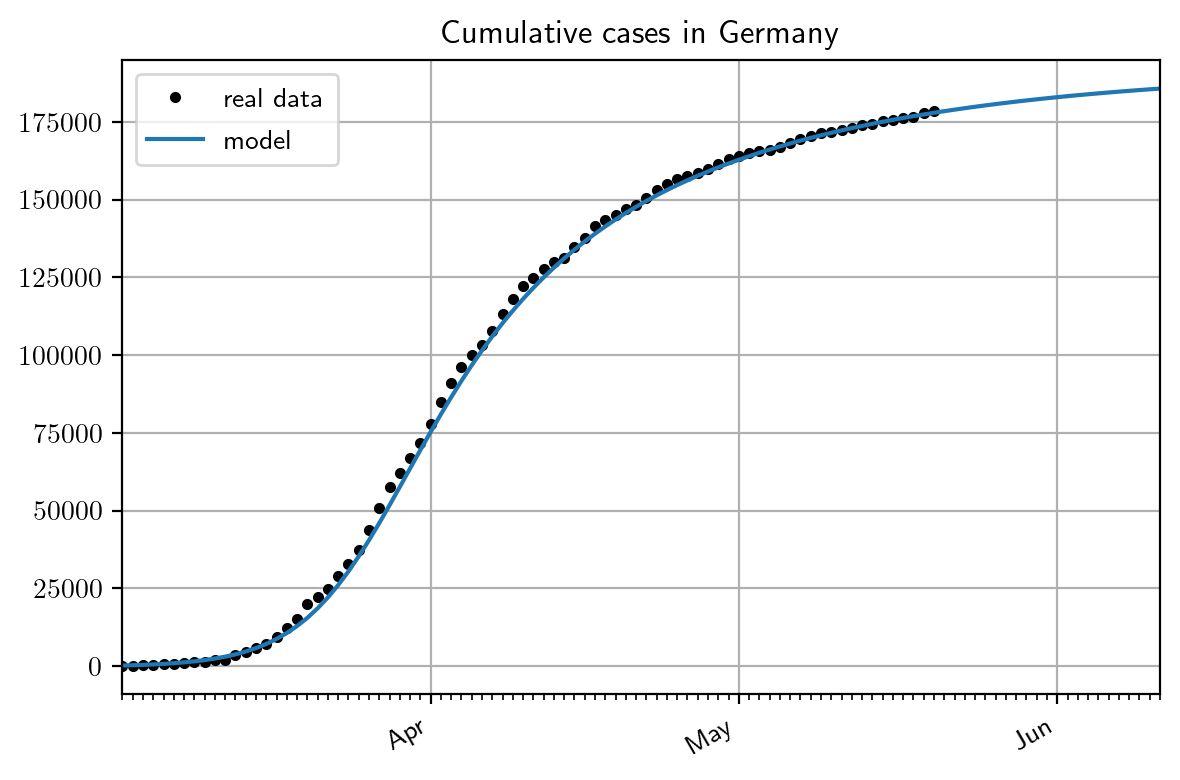

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.cbook as cbook
from datetime import date, timedelta


country_data = dataset.cumulative('Germany', rescaling=10000)
sysid = SysId(country_data, {'max_degree': 4, 'cutoff': 1e-20})
sysid.fit(verbose=2)
""
plotting_data = country_data[40:]

months = mdates.MonthLocator() 
days = mdates.DayLocator()
months_fmt = mdates.DateFormatter('%b')

datemin = date.today() - timedelta(days=len(plotting_data))
datemax = date.today() + timedelta(days=21)


r_date = [datemin + timedelta(days=x) for x in range(len(plotting_data))]
e_date = [datemin + timedelta(days=x) for x in range(len(plotting_data) + 22)]

fig, ax = plt.subplots(dpi=200)
ax.plot(r_date, plotting_data*10000, 'k.', label='real data')
ax.plot(e_date, sysid.trajectory([0.02], len(plotting_data) + 21)*10000, label='model')

# format the ticks
ax.xaxis.set_major_locator(months)
ax.xaxis.set_major_formatter(months_fmt)
ax.xaxis.set_minor_locator(days)

# round to nearest years.
ax.set_xlim(datemin, datemax)

# format the coords message box
ax.format_xdata = mdates.DateFormatter('%Y-%m-%d')
ax.format_ydata = lambda x: '$%1.2f' % x  # format the price.
ax.grid(True)
ax.legend()
# ax.set_ylabel('Cumulative cases')
ax.set_title('Cumulative cases in Germany')
# rotates and right aligns the x labels, and moves the bottom of the
# axes up to make room for them
fig.autofmt_xdate()

plt.tight_layout()

plt.savefig('germany.png', dpi=200)
plt.show()

$$x_{t+1} = 0.0036602875 + 1.2610624 \times x_t + -0.0278917 \times x_t^2 + 0.0010964029 \times x_t^3 + -1.622901e-05 \times x_t^4$$

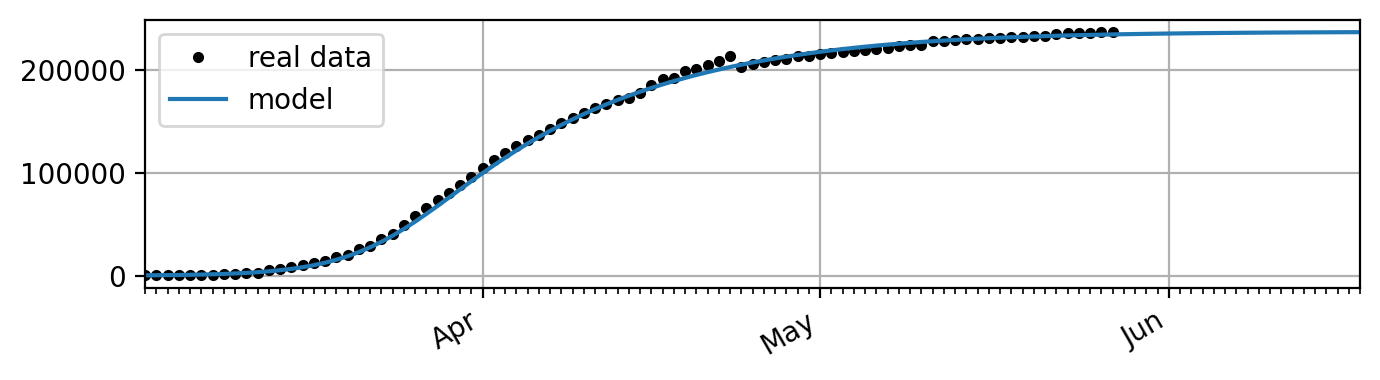

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.cbook as cbook
from datetime import date, timedelta


country_data = dataset.cumulative('Spain', rescaling=10000)
sysid = SysId(country_data, {'max_degree': 4, 'cutoff': 1e-20})
sysid.fit(verbose=2)

plotting_data = country_data[40:]

months = mdates.MonthLocator() 
days = mdates.DayLocator()
months_fmt = mdates.DateFormatter('%b')

datemin = date.today() - timedelta(days=len(plotting_data))
datemax = date.today() + timedelta(days=21)


r_date = [datemin + timedelta(days=x) for x in range(len(plotting_data))]
e_date = [datemin + timedelta(days=x) for x in range(len(plotting_data) + 22)]

fig, ax = plt.subplots(figsize=(7, 2), dpi=200)
ax.plot(r_date, plotting_data*10000, 'k.', label='real data')
ax.plot(e_date, sysid.trajectory([0.02], len(plotting_data) + 21)*10000, label='model')

# format the ticks
ax.xaxis.set_major_locator(months)
ax.xaxis.set_major_formatter(months_fmt)
ax.xaxis.set_minor_locator(days)

# round to nearest years.
ax.set_xlim(datemin, datemax)

# format the coords message box
ax.format_xdata = mdates.DateFormatter('%Y-%m-%d')
ax.format_ydata = lambda x: '$%1.2f' % x  # format the price.
ax.grid(True)
# ax.legend()
# rotates and right aligns the x labels, and moves the bottom of the
# axes up to make room for them
fig.autofmt_xdate()
plt.legend()

plt.tight_layout()

plt.savefig('figure.svg', format='svg')
plt.show()

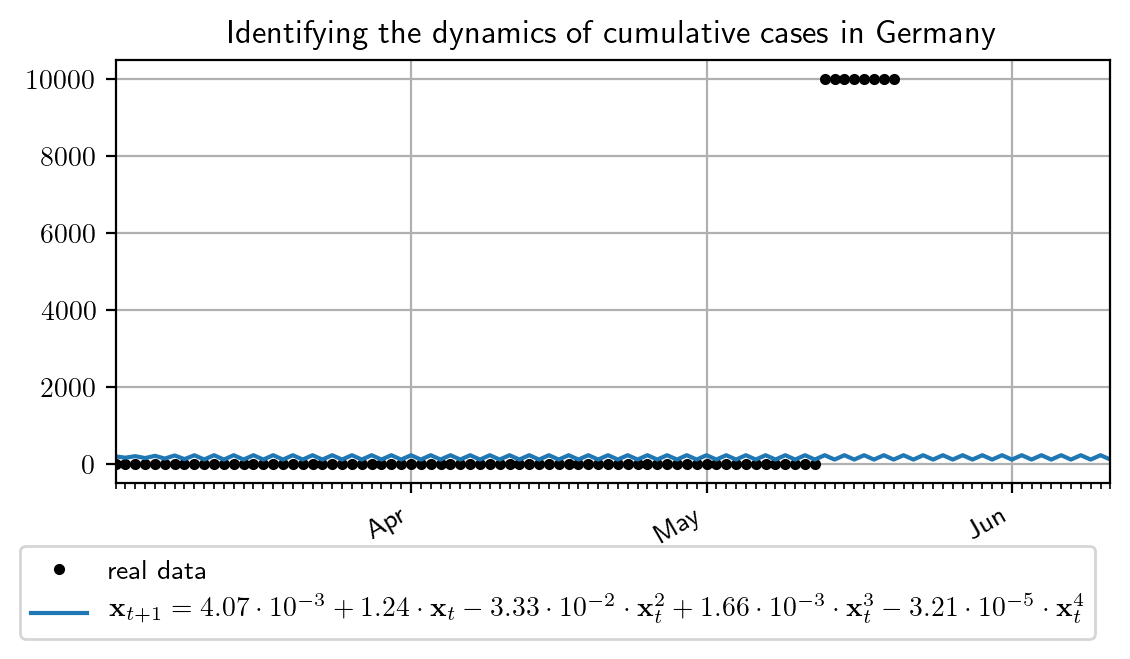

In [25]:
import matplotlib
matplotlib.rcParams['text.usetex'] = True

plotting_data = country_data[40:]

months = mdates.MonthLocator() 
days = mdates.DayLocator()
months_fmt = mdates.DateFormatter('%b')

datemin = date.today() - timedelta(days=len(plotting_data))
datemax = date.today() + timedelta(days=21)


r_date = [datemin + timedelta(days=x) for x in range(len(plotting_data))]
e_date = [datemin + timedelta(days=x) for x in range(len(plotting_data) + 22)]

fig, ax = plt.subplots(dpi=200, figsize=(6, 3.5))
ax.plot(r_date, plotting_data*10000, 'k.', label='real data')
ax.plot(e_date, sysid.trajectory([0.02], len(plotting_data) + 21)*10000, label='$\mathbf{x}_{t+1} = 4.07 \cdot 10^{-3} + 1.24 \cdot \mathbf{x}_t - 3.33 \cdot 10^{-2} \cdot \mathbf{x}_t^2 + 1.66 \cdot 10^{-3} \cdot \mathbf{x}_t^3 - 3.21 \cdot 10^{-5} \cdot \mathbf{x}_t^4$')

# format the ticks
ax.xaxis.set_major_locator(months)
ax.xaxis.set_major_formatter(months_fmt)
ax.xaxis.set_minor_locator(days)

# round to nearest years.
ax.set_xlim(datemin, datemax)

# format the coords message box
ax.format_xdata = mdates.DateFormatter('%Y-%m-%d')
ax.format_ydata = lambda x: '$%1.2f' % x  # format the price.
ax.grid(True)
ax.legend(loc='lower left', bbox_to_anchor=(-0.11, -0.4, 0., 0.))
# ax.set_ylabel('Cumulative cases')
ax.set_title('Identifying the dynamics of cumulative cases in Germany')
# rotates and right aligns the x labels, and moves the bottom of the
# axes up to make room for them
fig.autofmt_xdate()

plt.tight_layout()

plt.savefig('germany_formula.png', dpi=200)
plt.show() 

matplotlib.rcParams['text.usetex'] = False

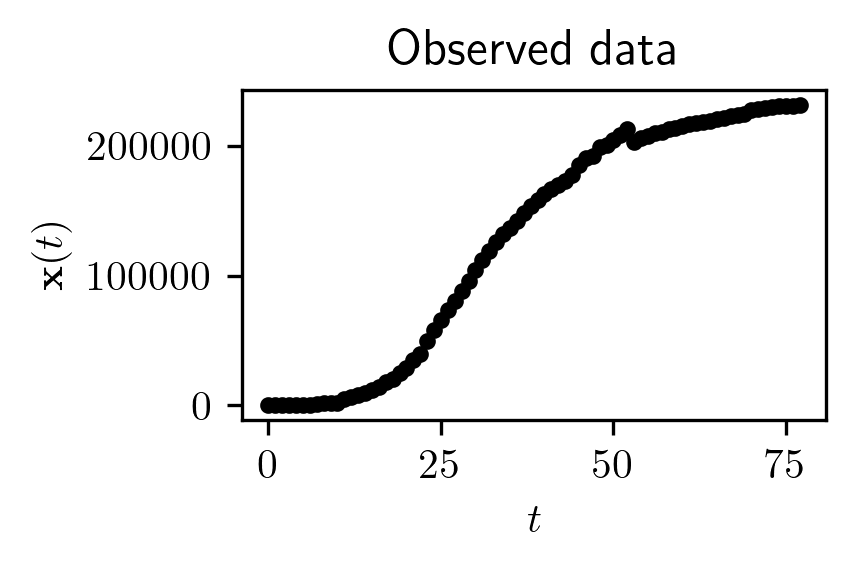

In [51]:
import matplotlib
matplotlib.rcParams['text.usetex'] = True

plotting_data = country_data[40:]

plt.figure(dpi=300, figsize=(3, 2))
plt.plot(plotting_data*10000, 'k.', label='real data')
plt.xlabel('$t$')
plt.ylabel('$\mathbf{x}(t)$')
plt.title('Observed data')
plt.tight_layout()
plt.savefig('observed_data.svg', format='svg')
plt.show() 

matplotlib.rcParams['text.usetex'] = False

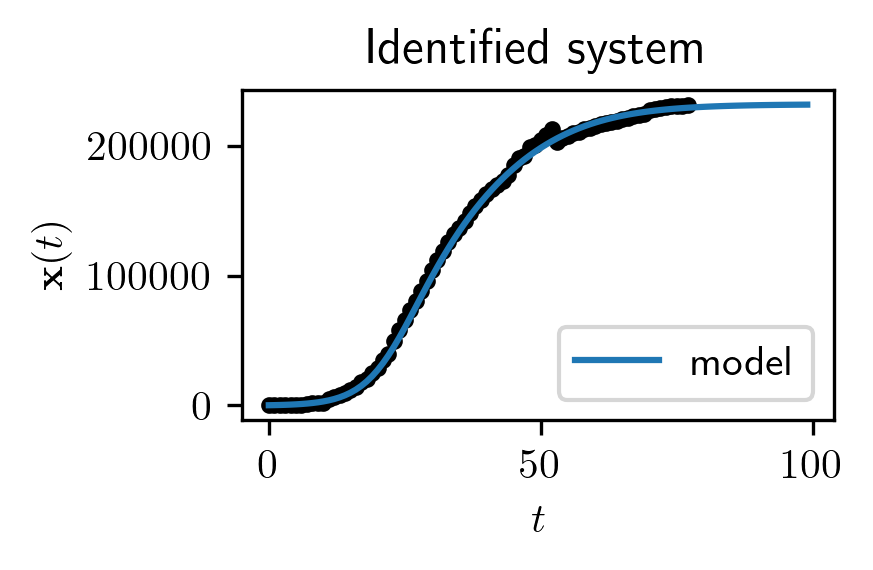

In [52]:
import matplotlib
matplotlib.rcParams['text.usetex'] = True

plotting_data = country_data[40:]

plt.figure(dpi=300, figsize=(3, 2))
plt.plot(plotting_data*10000, 'k.')
plt.plot(sysid.trajectory([0.02], len(plotting_data) + 21)*10000, label='model')
plt.xlabel('$t$')
plt.ylabel('$\mathbf{x}(t)$')
plt.title('Identified system')
plt.legend()
plt.tight_layout()
plt.savefig('identified_system.svg', format='svg')
plt.show() 

matplotlib.rcParams['text.usetex'] = False

Data-driven COVID modeling

The work around this topic is aimed at exploring the usage of a system identification tool called sparse identification of nonlinear dynamics for COVID-related data. So far, three directions were considered: (1) assessing the predictive power of models identified from the evolution of cumulative cases in a single country compared to classic time-series forecasting tools. (2) Including additional information about health, sanitation and measures in each country to study the influence of these factors on the evolution of the pandemic. (3) Identifying the dynamics from the evolution of susceptible, infected and recovered quantities in different countries and comparing them to classical SIR models. A more thorough review of this activity can be found here (link will be provided soon).

In [ ]:
country = 'Germany'
country2 = 'Spain'
degrees = [2, 3, 4, 5]
initial_values = [0.3, 0.1, 0.1, 0.1]

country_data = dataset.cumulative(country, rescaling=10000)
country_data2 = dataset.cumulative(country2, rescaling=10000)

f, (ax1, ax2) = plt.subplots(1, 2, dpi=200, figsize=(9, 3))

ax1.plot(country_data[45:]*10000, 'k.', label='real values')
ax2.plot(country_data2[45:]*10000, 'k.', label='real values')

for init, degree in zip(initial_values, degrees):
    sysid = SysId(country_data, {'max_degree': degree, 'cutoff': 1e-50})
    sysid.fit()
    trajectory = sysid.trajectory([init], 90)
    trajectory[trajectory > country_data[-1] * 2] = np.nan
    ax1.plot(trajectory*10000, label=f'max degree: {degree}')

    sysid = SysId(country_data2, {'max_degree': degree, 'cutoff': 1e-50})
    sysid.fit()
    trajectory = sysid.trajectory([init], 90)
    trajectory[trajectory > country_data[-1] * 2] = np.nan
    ax2.plot(trajectory*10000, label=f'max degree: {degree}')




ax1.set_title(country)
ax1.set_ylabel('cases')
ax1.set_xlabel('days')
ax1.legend()



ax2.set_title(country2)
ax2.set_xlabel('days')

plt.tight_layout()
plt.show()
# f.savefig('degrees.png', dpi=200)

## Evaluating the predictive power of SINDy for COVID-19 cases

